# Modern Portfolio Theory

MPT is about achieving the optimal balance between risk and reward through diversification


The main goal of MPT is to maximize returns while mitigating risks.



In [10]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize

In [11]:
# Define the cryptocurrencies and the index
cryptos = ['BTC-USD', 'ETH-USD', 'SOL-USD', 'BNB-USD', 'XRP-USD', 'TON-USD', 'DOGE-USD', 'ADA-USD', 'SHIB-USD', 'AVAX-USD']
index = 'BITW'

# Define the start and end dates
start_date = '2022-01-01'
end_date = '2024-01-01'

# Download data for the cryptocurrencies and the index
data = yf.download(cryptos + [index], start=start_date, end=end_date)['Adj Close']

[*********************100%%**********************]  11 of 11 completed


## Data Analysis

In [12]:
# Calculate daily returns
returns = data[cryptos].pct_change().dropna()

# Calculate mean returns and covariance matrix
mean_returns = returns.mean()
cov_matrix = returns.cov()

# Display the first few rows of the returns dataframe
print(returns.head())


Ticker       BTC-USD   ETH-USD   SOL-USD   BNB-USD   XRP-USD   TON-USD  \
Date                                                                     
2022-01-02 -0.007163  0.015881 -0.011960  0.007668  0.011355  0.045267   
2022-01-03 -0.018737 -0.017805 -0.034499 -0.036245 -0.030535  0.006494   
2022-01-04 -0.012066  0.008687 -0.013851 -0.009040 -0.009860  0.047271   
2022-01-05 -0.050734 -0.064224 -0.076451 -0.063938 -0.061012 -0.119286   
2022-01-06 -0.009366 -0.037173 -0.030099 -0.003750  0.009024 -0.014931   

Ticker      DOGE-USD   ADA-USD  SHIB-USD  AVAX-USD  
Date                                                
2022-01-02  0.007906  0.000442  0.000000 -0.008512  
2022-01-03 -0.024742 -0.040612 -0.029412 -0.044538  
2022-01-04 -0.007555 -0.007550 -0.030303 -0.045365  
2022-01-05 -0.055586 -0.057680 -0.062500 -0.052177  
2022-01-06  0.004974  0.035421  0.033333 -0.027123  


## Portfolio Optimization

In [13]:
def portfolio_performance(weights, mean_returns, cov_matrix):
    returns = np.dot(weights, mean_returns)
    risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return returns, risk

def negative_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_returns, p_risk = portfolio_performance(weights, mean_returns, cov_matrix)
    return -(p_returns - risk_free_rate) / p_risk

def optimize_portfolio(mean_returns, cov_matrix, risk_free_rate=0.01):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(num_assets))
    init_guess = num_assets * [1. / num_assets]
    result = minimize(negative_sharpe_ratio, init_guess, args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result

# Optimize the portfolio
result = optimize_portfolio(mean_returns, cov_matrix)
optimal_weights = result.x
print('Optimal Weights:', optimal_weights)


Optimal Weights: [1.31656255e-16 0.00000000e+00 1.00000000e+00 6.65050639e-17
 0.00000000e+00 1.32334665e-16 3.55637578e-17 1.48634364e-16
 0.00000000e+00 0.00000000e+00]


## Visualization

/var/folders/sd/j5p08m515kd7n9549lkkz_q40000gn/T/ipykernel_85155/3986156438.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.scatter(max_sharpe_port[0], max_sharpe_port[1], marker='*', color='r', s=500, label='Max Sharpe Ratio')
/var/folders/sd/j5p08m515kd7n9549lkkz_q40000gn/T/ipykernel_85155/3986156438.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.scatter(min_risk_port[0], min_risk_port[1], marker='*', color='b', s=500, label='Min Risk')


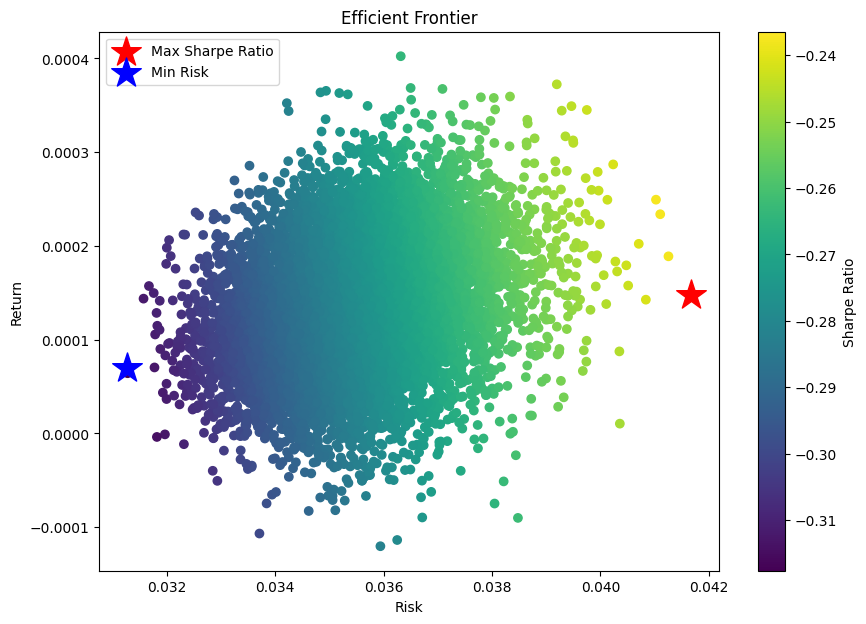

In [14]:
# Plot the efficient frontier
def plot_efficient_frontier(mean_returns, cov_matrix, num_portfolios=10000, risk_free_rate=0.01):
    results = np.zeros((3, num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(len(mean_returns))
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_return, portfolio_risk = portfolio_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_risk
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_risk

    results_frame = pd.DataFrame(results.T, columns=['Risk','Return','Sharpe'])
    weights_frame = pd.DataFrame(weights_record, columns=cryptos)

    max_sharpe_idx = results_frame['Sharpe'].idxmax()
    max_sharpe_port = results_frame.iloc[max_sharpe_idx]
    min_risk_idx = results_frame['Risk'].idxmin()
    min_risk_port = results_frame.iloc[min_risk_idx]

    plt.figure(figsize=(10, 7))
    plt.scatter(results_frame.Risk, results_frame.Return, c=results_frame.Sharpe, cmap='viridis')
    plt.colorbar(label='Sharpe Ratio')
    plt.scatter(max_sharpe_port[0], max_sharpe_port[1], marker='*', color='r', s=500, label='Max Sharpe Ratio')
    plt.scatter(min_risk_port[0], min_risk_port[1], marker='*', color='b', s=500, label='Min Risk')
    plt.title('Efficient Frontier')
    plt.xlabel('Risk')
    plt.ylabel('Return')
    plt.legend()
    plt.show()

# Plot efficient frontier
plot_efficient_frontier(mean_returns, cov_matrix)


## Individual Risk-Return Profile Analysis

/var/folders/sd/j5p08m515kd7n9549lkkz_q40000gn/T/ipykernel_85155/530856402.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (individual_risks[i], individual_returns[i]), fontsize=12)


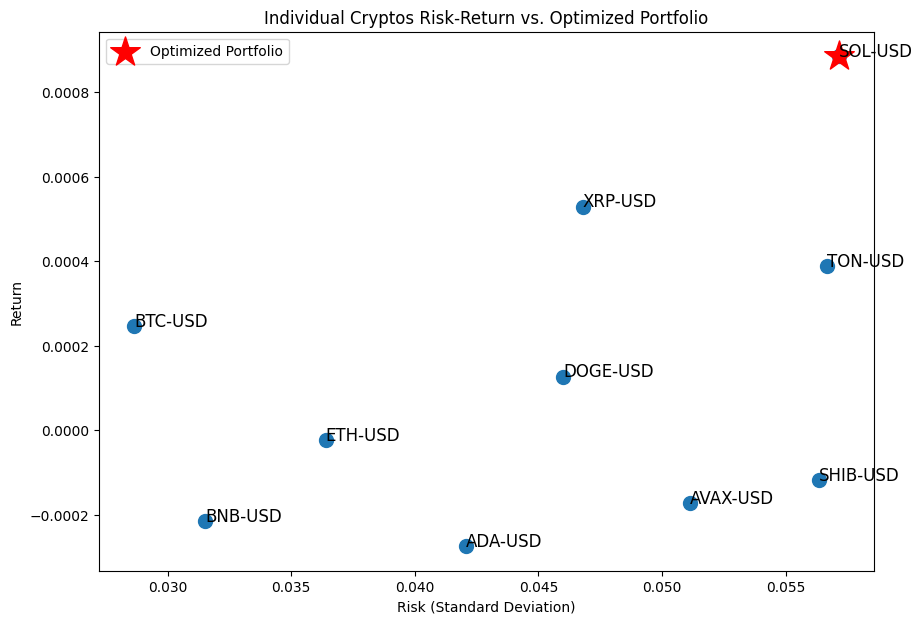

In [15]:
def plot_individual_cryptos(mean_returns, cov_matrix, optimal_weights):
    individual_risks = np.sqrt(np.diag(cov_matrix))
    individual_returns = mean_returns

    portfolio_return, portfolio_risk = portfolio_performance(optimal_weights, mean_returns, cov_matrix)

    plt.figure(figsize=(10, 7))
    plt.scatter(individual_risks, individual_returns, marker='o', s=100)
    for i, txt in enumerate(mean_returns.index):
        plt.annotate(txt, (individual_risks[i], individual_returns[i]), fontsize=12)
    
    plt.scatter(portfolio_risk, portfolio_return, marker='*', color='r', s=500, label='Optimized Portfolio')
    plt.title('Individual Cryptos Risk-Return vs. Optimized Portfolio')
    plt.xlabel('Risk (Standard Deviation)')
    plt.ylabel('Return')
    plt.legend()
    plt.show()

# Plot individual cryptos risk-return profile
plot_individual_cryptos(mean_returns, cov_matrix, optimal_weights)


## Monte Carlo Simulation

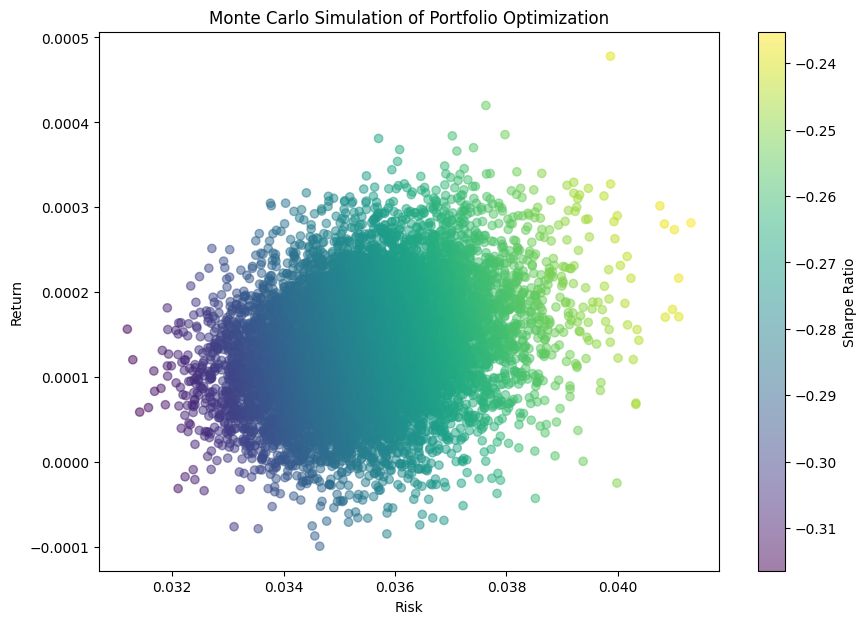

In [16]:
def monte_carlo_simulation(mean_returns, cov_matrix, num_simulations=10000):
    results = np.zeros((3, num_simulations))
    for i in range(num_simulations):
        weights = np.random.random(len(mean_returns))
        weights /= np.sum(weights)
        portfolio_return, portfolio_risk = portfolio_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_risk
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - 0.01) / portfolio_risk

    results_frame = pd.DataFrame(results.T, columns=['Risk','Return','Sharpe'])

    plt.figure(figsize=(10, 7))
    plt.scatter(results_frame.Risk, results_frame.Return, c=results_frame.Sharpe, cmap='viridis', alpha=0.5)
    plt.colorbar(label='Sharpe Ratio')
    plt.title('Monte Carlo Simulation of Portfolio Optimization')
    plt.xlabel('Risk')
    plt.ylabel('Return')
    plt.show()

# Perform Monte Carlo simulation
monte_carlo_simulation(mean_returns, cov_matrix)


## Comparison with Benchmark Index


/var/folders/sd/j5p08m515kd7n9549lkkz_q40000gn/T/ipykernel_85155/2348013167.py:2: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  benchmark_returns = data[index].pct_change().dropna()


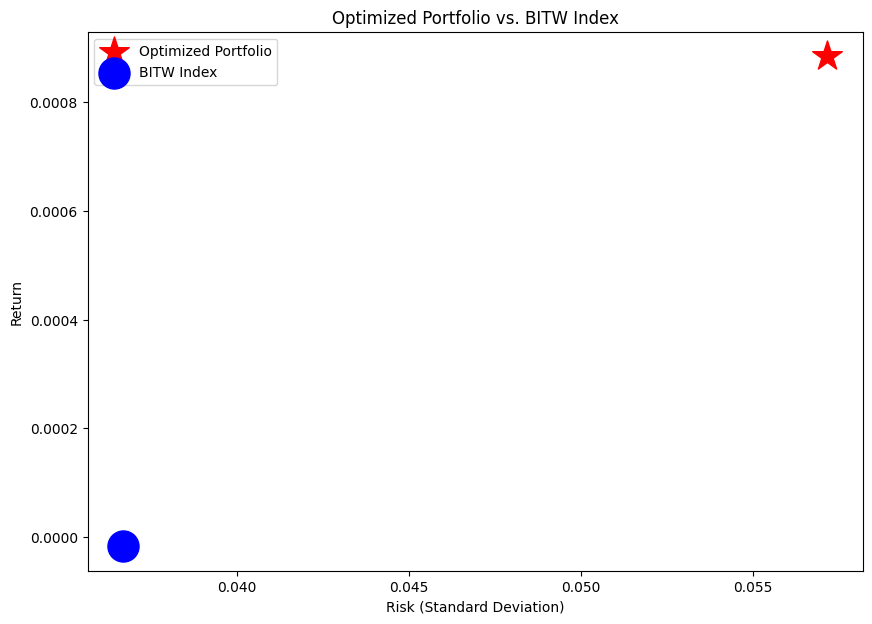

Optimized Portfolio Return: 0.0008848761351816661
Optimized Portfolio Risk: 0.057152788178600644
BITW Index Return: -1.6924858139849113e-05
BITW Index Risk: 0.03668350292099397


In [17]:
# Calculate benchmark index performance
benchmark_returns = data[index].pct_change().dropna()

benchmark_mean_return = benchmark_returns.mean()
benchmark_risk = benchmark_returns.std()

# Calculate optimized portfolio performance
portfolio_return, portfolio_risk = portfolio_performance(optimal_weights, mean_returns, cov_matrix)

plt.figure(figsize=(10, 7))
plt.scatter(portfolio_risk, portfolio_return, marker='*', color='r', s=500, label='Optimized Portfolio')
plt.scatter(benchmark_risk, benchmark_mean_return, marker='o', color='b', s=500, label='BITW Index')
plt.title('Optimized Portfolio vs. BITW Index')
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Return')
plt.legend()
plt.show()

print(f'Optimized Portfolio Return: {portfolio_return}')
print(f'Optimized Portfolio Risk: {portfolio_risk}')
print(f'BITW Index Return: {benchmark_mean_return}')
print(f'BITW Index Risk: {benchmark_risk}')


## Sensitivity Analysis

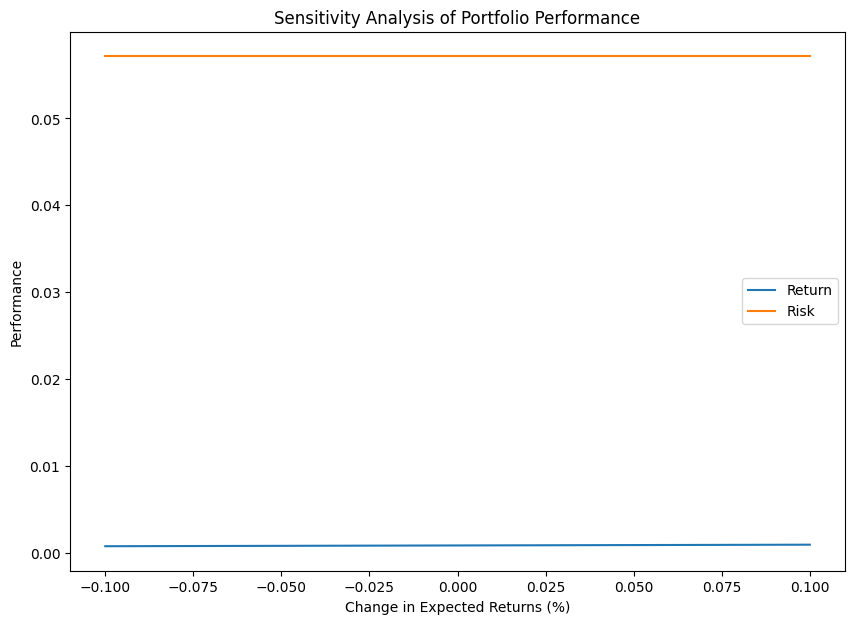

In [18]:
def sensitivity_analysis(mean_returns, cov_matrix, risk_free_rate=0.01):
    sensitivity_results = []
    for delta in np.linspace(-0.1, 0.1, 10):  # Adjust the delta range as needed
        adjusted_returns = mean_returns * (1 + delta)
        result = optimize_portfolio(adjusted_returns, cov_matrix, risk_free_rate)
        optimal_weights = result.x
        portfolio_return, portfolio_risk = portfolio_performance(optimal_weights, adjusted_returns, cov_matrix)
        sensitivity_results.append((delta, portfolio_return, portfolio_risk))

    sensitivity_df = pd.DataFrame(sensitivity_results, columns=['Delta', 'Return', 'Risk'])
    
    plt.figure(figsize=(10, 7))
    plt.plot(sensitivity_df['Delta'], sensitivity_df['Return'], label='Return')
    plt.plot(sensitivity_df['Delta'], sensitivity_df['Risk'], label='Risk')
    plt.title('Sensitivity Analysis of Portfolio Performance')
    plt.xlabel('Change in Expected Returns (%)')
    plt.ylabel('Performance')
    plt.legend()
    plt.show()

# Perform sensitivity analysis
sensitivity_analysis(mean_returns, cov_matrix)


## Backtesting

/var/folders/sd/j5p08m515kd7n9549lkkz_q40000gn/T/ipykernel_85155/1086035661.py:7: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  plt.plot((1 + data[index].pct_change().dropna()).cumprod() - 1, label='BITW Index')


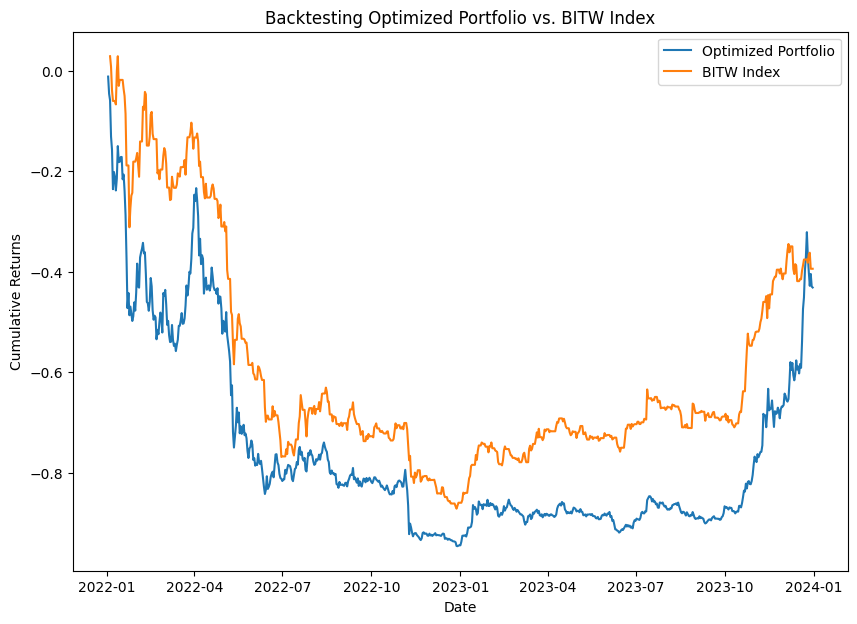

In [19]:
def backtest_portfolio(data, weights):
    portfolio_returns = (data[cryptos].pct_change().dropna() * weights).sum(axis=1)
    cumulative_returns = (1 + portfolio_returns).cumprod() - 1

    plt.figure(figsize=(10, 7))
    plt.plot(cumulative_returns, label='Optimized Portfolio')
    plt.plot((1 + data[index].pct_change().dropna()).cumprod() - 1, label='BITW Index')
    plt.title('Backtesting Optimized Portfolio vs. BITW Index')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.show()

# Backtest the optimized portfolio
backtest_portfolio(data, optimal_weights)
